# Machine Learning CT Data 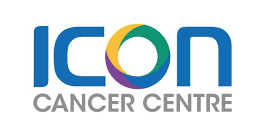
## David Jolly, Senior Medical Physicist
### Icon Cancer Centre

### Abridged Data Dictionary

There are 39 columns of data within this set, the below dictionary is abridged to display only information pertinent to this study.

| Field | Description
| :--- | :---
| **PatientID** | Anonymised unique patient identifier - Primary Key
| **StudyDate** | Date that image was taken, format is DD/MM/YYYY hh:mm:ss
| **Manufacturer** | Vendor whom produced imaging system (CT or MR)
| **Model** | Model of imaging system
| **Institution** | Location where scanner is located
| **Modality** | CT or MR, only interested in CT data for this work, so MR will be filtered out
| **BodyRegion** | Anatomical region of scanned patient, IMPORTANT DATA
| **srt** | Stands for 'stereotactic radiation therapy'. 0 = non-stereo and 1 = stereo. Scan parameters may differ between techniques and thus data may need to be filtered and analysed independently. 
| **SliceThickness** | Physical distance between image slices (mm)
| **kVP** | Kilovoltage peak is the peak potential (V) applied to the CT X-ray tube
| **ReconstructionDiameter** | Diameter of reconstructed image (mm)
| **ExposureTime** | Total time of radiation exposure (ms)
| **TubeCurrent** | Current applied to kV tube (mA), a higher number represents more X-rays and thus a 'stronger' beam
| **FilterType** | Type of filtration used on X-ray beam
| **FocalSpotSize** | Focal spot size on X-ray target (mm), smaller values give better resolution
| **ConvolutionKernal** | Algorithm used to reconstruct images from raw data
| **PatientPosition** | Orientation of patient when scanned. HFS = head first supine, FFS = feet first supine, HFP = head first prone, HFDL = head first-decubitus left, HFDR = head first-decubitus reft, FFDL = feet first-decubitus left, FFDR = feet first-decubitus left. FFP = feet first prone
| **CTDIvol** | CT dose index (mGy), measure of patient x-ray dose. Want to minimise value without compromising image quality.

In [1]:
#Importing Libraries

import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
#Importing Raw csv data
def import_ctic():
    return pd.read_csv('../input/ic-data/Image_Compliance_DATA.csv')

ctic = import_ctic()

## Data Cleaning

In [3]:
#Dropping all non-CT data (MR and PT)
ctic.drop(ctic[ctic['Modality'] == 'MR'].index, inplace = True)
ctic.drop(ctic[ctic['Modality'] == 'PT'].index, inplace = True)

#Filling in several columns that contain NaN
ctic.fillna({'FilterType': 'Filter Unknown', 'Institution':'Institution Unknown'}, inplace=True)

#Converting 'StudyDate' to DateTime format
ctic['StudyDate'] = pd.to_datetime(ctic['StudyDate'])

#Dropping rows without a specified BodyRegion
ctic.drop(ctic[ctic['BodyRegion'] == '(body region unspecified)'].index, inplace = True)

#Removing all data from one scanner as it is an outlier and skews the data
ctic.drop(ctic[(ctic.Institution == 'QXR St Andrews')].index, inplace = True)


### Presenting cleaned data columns of interest

In [4]:
ctic_clean = ctic[[ 'StudyDate',
                    'Manufacturer',
                    'Model',
                    'Institution',
                    'BodyRegion',
                    'TubeCurrent',
                    'PatientPosition',
                    'CTDIvol',
                    'ConvolutionKernal',
                    'kVP',
                    'srt',
                    'SliceThickness',
                    'ExposureTime']]
ctic_clean.head(5)

,StudyDate,Manufacturer,Model,Institution,BodyRegion,TubeCurrent,PatientPosition,CTDIvol,ConvolutionKernal,kVP,srt,SliceThickness,ExposureTime
1,2021-04-14,GE MEDICAL SYSTEMS,Optima CT660,Windsor Gardens Oncology,Pelvis,411,HFS,0.000000,STANDARD,120,0,2.5,600
3,2021-04-15,SIEMENS,SOMATOM Confidence,ICON Midland,Chest,155,HFS,8.019834,Bf37f,120,0,2.0,500
4,2021-04-19,TOSHIBA,Aquilion ONE,QXR GCPH,Head,300,HFS,79.600000,FC26,120,1,1.0,750
5,2021-04-20,TOSHIBA,Aquilion ONE,QXR GCPH,Chest,150,HFS,10.300000,FC13,120,0,2.0,500
6,2021-04-20,SIEMENS,SOMATOM Confidence,ICON Midland,Chest,515,HFS,26.646544,Bf37f,120,0,2.0,500


In [5]:
#Creating a new DataFrame that removes all rows with a CTDIvol value of 0 (some CT scanners do not report this value)
drop_ctdi0 = ctic_clean.drop(ctic_clean[(ctic_clean.CTDIvol == 0)].index)

## Set-up for decision Tree

In [6]:
# Create target object and call it y
y = drop_ctdi0.TubeCurrent

# Create X
#['BodyRegion', 'kVP','srt', 'SliceThickness', 'ExposureTime'] srt and SliceThickness have no impact on model accuracy
features = ['BodyRegion', 'kVP', 'ExposureTime']
X = drop_ctdi0[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

#Encoding categorical BodyRegion data with dummy values
one_hot_encoded_train_X = pd.get_dummies(train_X)
one_hot_encoded_val_X = pd.get_dummies(val_X)
final_train, final_val = one_hot_encoded_train_X.align(one_hot_encoded_val_X, join='left', axis=1)

# Specify Model
ctdi_model = DecisionTreeRegressor(max_leaf_nodes=25, random_state=1)
# Fit Model
ctdi_model.fit(final_train, train_y)

# Make validation predictions and calculate mean absolute error
TubeCurrent_predictions = ctdi_model.predict(final_val)
TubeCurrent_mae = mean_absolute_error(TubeCurrent_predictions, val_y)
print("Validation MAE with optimal max_leaf_nodes: {:,.0f} mAs".format(TubeCurrent_mae))

Validation MAE with optimal max_leaf_nodes: 114 mAs


## Random Forest

In [7]:
from sklearn.ensemble import RandomForestRegressor

# Define the model. Set random_state to 1
rf_model = RandomForestRegressor(random_state=1)

# fit your model
rf_model.fit(final_train, train_y)

# Calculate the mean absolute error of your Random Forest model on the validation data
rf_val_predictions = rf_model.predict(final_val)
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)

print("Validation MAE for Random Forest Model: {}".format(rf_val_mae))

Validation MAE for Random Forest Model: 114.38199862252887
